In [46]:
import pandas as pd
import networkx as nx
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Base path for data
BASE = '../data/'

In [47]:
# Step 1: Load Data
product_data = pd.read_csv(BASE + 'products.csv')
edges_data = pd.read_csv(BASE + 'edges.csv')

# Clean the data
product_data_clean = product_data.dropna(subset=['average_rating', 'num_reviews', 'salesrank'])
product_data_clean['average_rating'] = pd.to_numeric(product_data_clean['average_rating'], errors='coerce')
product_data_clean['num_reviews'] = pd.to_numeric(product_data_clean['num_reviews'], errors='coerce')
product_data_clean['salesrank'] = pd.to_numeric(product_data_clean['salesrank'], errors='coerce')
product_data_clean = product_data_clean.dropna(subset=['average_rating', 'num_reviews', 'salesrank'])


/var/folders/4q/_v913tvd0cl08n5b85ff8b6r0000gn/T/ipykernel_25797/3702903549.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  product_data_clean['average_rating'] = pd.to_numeric(product_data_clean['average_rating'], errors='coerce')
/var/folders/4q/_v913tvd0cl08n5b85ff8b6r0000gn/T/ipykernel_25797/3702903549.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  product_data_clean['num_reviews'] = pd.to_numeric(product_data_clean['num_reviews'], errors='coerce')
/var/folders/4q/_v913tvd0cl08n5b85ff8b6r0000gn

In [48]:
# Step 2: Create the Graph for Bundles (Co-purchase Relationships)
G = nx.Graph()
for _, row in edges_data.iterrows():
    G.add_edge(row['source'], row['target'])

# Find connected components (i.e., bundles of products frequently bought together)
bundles = list(nx.connected_components(G))

In [59]:
# Step 3: Create Bundle Features
bundle_features = []
bundle_revenue_scores = []

# Create a mapping from ASIN to product metadata for easy lookup
product_metadata = product_data_clean.set_index('ASIN').to_dict(orient='index')

valid_bundles = []

# Loop over each bundle to create features
for bundle in bundles:
    known_asins = [asin for asin in bundle if asin in product_metadata]
    num_known = len(known_asins)
    num_total = len(bundle)
    
    # Skip bundle if less than 80% of products are known
    if num_total == 0 or num_known / num_total < 0.8:
        continue

    bundle_salesrank = 0
    bundle_num_reviews = 0
    bundle_avg_rating = 0
    
    for asin in known_asins:
        product = product_metadata[asin]
        bundle_salesrank += product['salesrank']
        bundle_num_reviews += product['num_reviews']
        bundle_avg_rating += product['average_rating']
    
    bundle_avg_rating /= num_known
    bundle_salesrank /= num_known
    bundle_num_reviews /= num_known

    if bundle_salesrank != 0:
        revenue_score = (bundle_num_reviews * bundle_avg_rating) / bundle_salesrank
    else:
        revenue_score = 0

    bundle_features.append([bundle_salesrank, bundle_num_reviews, bundle_avg_rating, num_known])
    bundle_revenue_scores.append(revenue_score)
    valid_bundles.append(known_asins)

# Convert bundle features and revenue scores into a DataFrame
df_bundles = pd.DataFrame(bundle_features, columns=['avg_salesrank', 'avg_num_reviews', 'avg_rating', 'bundle_size'])
df_bundles['revenue_score'] = bundle_revenue_scores

In [60]:
# Step 4: Split Data for Training and Testing
X = df_bundles[['avg_salesrank', 'avg_num_reviews', 'avg_rating', 'bundle_size']]
y = df_bundles['revenue_score']

# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Train Decision Tree Regressor
model = DecisionTreeRegressor(random_state=42)
model.fit(X_train, y_train)

# Step 6: Make Predictions
y_pred = model.predict(X_test)

# Step 7: Evaluate the Model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Output Results
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

feature_importances = model.feature_importances_
print(f"Feature Importances: {dict(zip(X.columns, feature_importances))}")

# Save the model and the processed data (optional)
df_bundles.to_csv(BASE + 'bundles.csv', index=False)


RMSE: 0.0012
R² Score: 0.5774
Feature Importances: {'avg_salesrank': np.float64(0.6008491225056702), 'avg_num_reviews': np.float64(0.37973135211927583), 'avg_rating': np.float64(0.0075224784677519274), 'bundle_size': np.float64(0.011897046907301983)}


/var/folders/4q/_v913tvd0cl08n5b85ff8b6r0000gn/T/ipykernel_25797/3899133954.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')


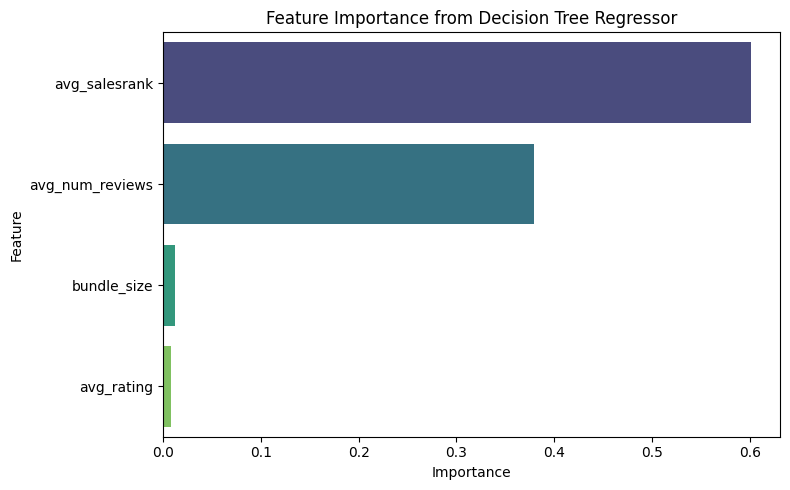

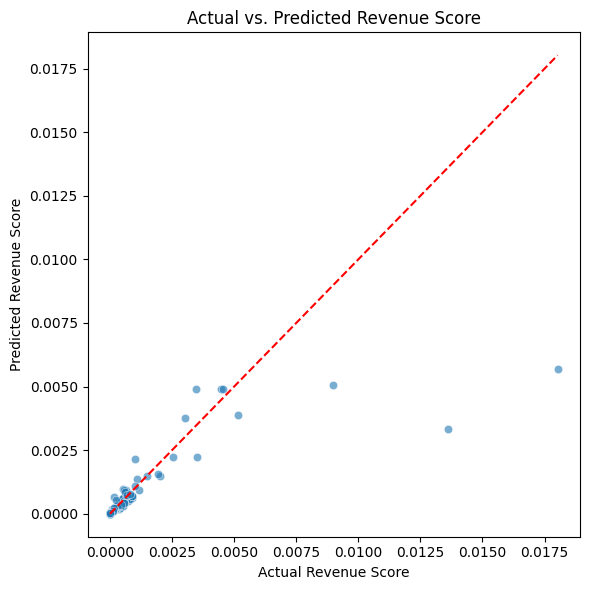


Top 5 Bundle Recommendations:

Bundle #532
Revenue Score: 0.02
Average Rating: 4.31, Reviews: 166, Sales Rank: 39747
Products:
 - Birds of Pray (Bonus DVD)
 - V
 - Throwing Copper [Bonus Disc]
 - The Distance to Here
 - Throwing Copper
 - Mental Jewelry
 - Birds of Pray
 - Secret Samadhi

Bundle #266
Revenue Score: 0.01
Average Rating: 4.29, Reviews: 75, Sales Rank: 23616
Products:
 - Pokémon 4Ever
 - Pokemon the First Movie - Mewtwo vs. Mew
 - Pokemon 3 - The Movie
 - Pokemon -  The Movie 2000
 - Pokemon Movie Collection  (The First Movie/The Movie 2000/Pokemon 3)
 - Pokemon 3 - The Movie
 - Pokemon - Mewtwo Returns
 - Pokemon Movie Collection  (The First Movie/The Movie 2000/Pokemon 3)
 - Pokemon - Mewtwo Returns
 - Pokémon 4Ever
 - Pokemon - The Movie 2000
 - Pokemon - Mewtwo Returns
 - Pokemon 3 - The Movie
 - Pokemon the First Movie: Mewtwo vs. Mew

Bundle #40
Revenue Score: 0.01
Average Rating: 4.50, Reviews: 15, Sales Rank: 7568
Products:
 - Wee Sing: The Marvelous Musical Mans

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import pandas as pd

# -----------------------------
# Step 0: Ensure Valid Bundle List Used
# -----------------------------

# Set the valid ASIN list in the same order as df_bundles
df_bundles['ASIN_list'] = valid_bundles

# -----------------------------
# Step 1: Enhance Bundle Data with Titles
# -----------------------------

# Map ASINs to product titles using the same cleaned dataset used in modeling
asin_to_title = product_data_clean.set_index('ASIN')['title'].to_dict()

def get_titles(asins):
    return [asin_to_title.get(asin, 'Unknown') for asin in asins]

# Add product titles to df_bundles
df_bundles['product_titles'] = df_bundles['ASIN_list'].apply(get_titles)

# Sort bundles by revenue_score (descending)
top_bundles = df_bundles.sort_values(by='revenue_score', ascending=False)

# Save top bundles to CSV
top_bundles.to_csv(BASE + 'top_bundles.csv', index=False)

# -----------------------------
# Step 2: Visualize Feature Importance
# -----------------------------
plt.figure(figsize=(8, 5))

# Create DataFrame for feature importances
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Barplot for feature importance
sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')
plt.title('Feature Importance from Decision Tree Regressor')
plt.tight_layout()
plt.savefig(BASE + 'feature_importance.png')
plt.show()

# -----------------------------
# Step 3: Predicted vs Actual Plot
# -----------------------------
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Diagonal line
plt.xlabel('Actual Revenue Score')
plt.ylabel('Predicted Revenue Score')
plt.title('Actual vs. Predicted Revenue Score')
plt.tight_layout()
plt.savefig(BASE + 'regression_scatter.png')
plt.show()

# -----------------------------
# Step 4: Print Top 5 Bundle Recommendations
# -----------------------------
print("\nTop 5 Bundle Recommendations:")
for idx, row in top_bundles.head(5).iterrows():
    print(f"\nBundle #{idx + 1}")
    print(f"Revenue Score: {row['revenue_score']:.2f}")
    print(f"Average Rating: {row['avg_rating']:.2f}, Reviews: {int(row['avg_num_reviews'])}, Sales Rank: {int(row['avg_salesrank'])}")
    print("Products:")
    for title in row['product_titles']:
        print(f" - {title}")
